In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import plot_tree

from sklearn.inspection import permutation_importance

## Data preparation

In [10]:
df = pd.read_csv('data/Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
X = df.drop(columns=['churn', 'customer_id'])
y = df['churn']

In [12]:
y.value_counts()

0    7963
1    2037
Name: churn, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111, shuffle=True, stratify=y)

In [14]:
y_train.value_counts()

0    5335
1    1365
Name: churn, dtype: int64

In [15]:
y_test.value_counts()

0    2628
1     672
Name: churn, dtype: int64

In [16]:
enc = OneHotEncoder(handle_unknown='ignore', drop='if_binary')
X_train_oh = enc.fit_transform(X_train[['country', 'gender']])
X_test_oh = enc.transform(X_test[['country', 'gender']])

column_name = enc.get_feature_names_out(['country', 'gender'])
X_train_oh = pd.DataFrame(X_train_oh.toarray(), columns=column_name, index=X_train.index)
X_test_oh = pd.DataFrame(X_test_oh.toarray(), columns=column_name, index=X_test.index)

X_train_num =  pd.concat([X_train.drop(columns=['country', 'gender']), X_train_oh], axis=1)
X_test_num =  pd.concat([X_test.drop(columns=['country', 'gender']), X_test_oh], axis=1)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

## Train

### Logistic Regression

In [34]:
clf_lr = LogisticRegression(random_state=111, C=1)
clf_lr.fit(X_train_scaled, y_train)

y_pred_lr = clf_lr.predict(X_test_scaled)

In [35]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2628
           1       0.57      0.21      0.31       672

    accuracy                           0.81      3300
   macro avg       0.70      0.58      0.60      3300
weighted avg       0.77      0.81      0.77      3300



In [36]:
confusion_matrix(y_test, y_pred_lr)

array([[2521,  107],
       [ 531,  141]])

In [42]:
df_odds = pd.DataFrame({
    'feature_name' : X_train_num.columns,
    'odds' : np.exp(clf_lr.coef_[0]).round(2),
    'std' : X_train_num.std().round(2)
})

df_odds.sort_values('odds', ascending=False)

,feature_name,odds,std
age,age,2.15,10.45
country_Germany,country_Germany,1.30,0.43
balance,balance,1.15,62240.55
credit_card,credit_card,1.01,0.46
estimated_salary,estimated_salary,0.99,57691.66
tenure,tenure,0.94,2.88
products_number,products_number,0.94,0.58
credit_score,credit_score,0.92,96.70
country_Spain,country_Spain,0.90,0.43
country_France,country_France,0.87,0.50


### Decision Tree Classifier

In [29]:
clf_dt = DecisionTreeClassifier(random_state=111, max_depth=3, splitter='best', 
                                min_samples_split=4, min_samples_leaf=2, max_leaf_nodes=7)

clf_dt.fit(X_train_num, y_train)

y_pred_dt = clf_dt.predict(X_test_num)

In [30]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      2628
           1       0.82      0.27      0.41       672

    accuracy                           0.84      3300
   macro avg       0.83      0.63      0.66      3300
weighted avg       0.84      0.84      0.81      3300



In [16]:
confusion_matrix(y_test, y_pred_dt)

array([[2587,   41],
       [ 489,  183]])

#### Feature importances (information gain)

In [17]:
df_imp_dt = pd.DataFrame({
    'feature_name' : X_train_num.columns,
    'feature_importance' : clf_dt.feature_importances_
})

df_imp_dt.sort_values('feature_importance', ascending=False)

,feature_name,feature_importance
1,age,0.537094
4,products_number,0.289183
6,active_member,0.173723
0,credit_score,0.000000
2,tenure,0.000000
3,balance,0.000000
5,credit_card,0.000000
7,estimated_salary,0.000000
8,country_France,0.000000
9,country_Germany,0.000000


#### Visualisation fo tree

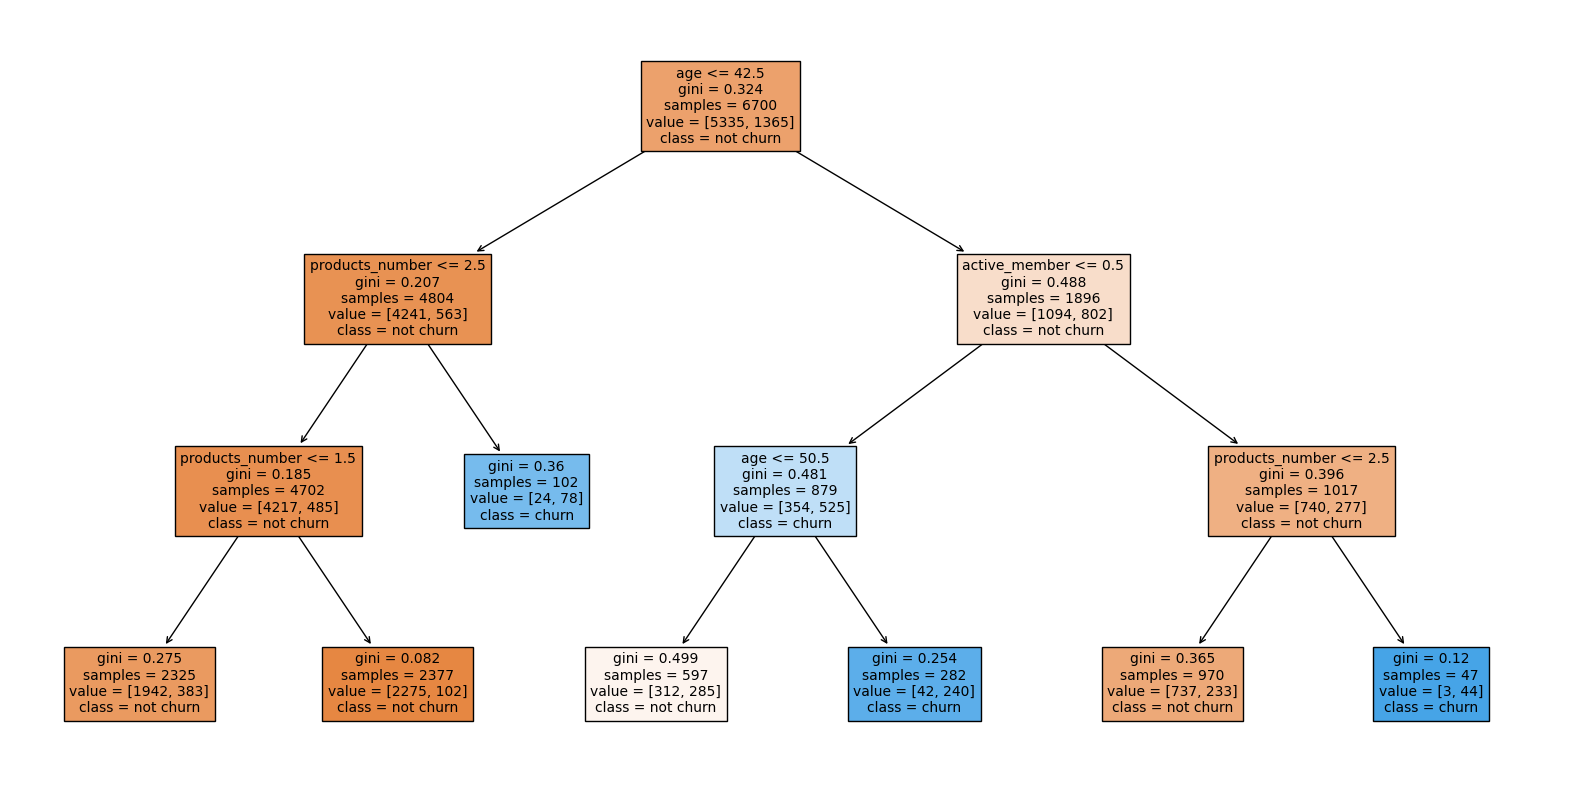

In [18]:
plt.figure(figsize=(20,10))
plot_tree(clf_dt, filled=True, feature_names=X_train_num.columns, class_names=['not churn', 'churn'], fontsize=10)
plt.show()

### Random Forest Classifier

In [19]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=111, class_weight='balanced')

clf_rf.fit(X_train_num, y_train)

y_pred_rf = clf_rf.predict(X_test_num)

In [20]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2628
           1       0.76      0.44      0.56       672

    accuracy                           0.86      3300
   macro avg       0.82      0.70      0.74      3300
weighted avg       0.85      0.86      0.84      3300



In [21]:
confusion_matrix(y_test, y_pred_rf)

array([[2533,   95],
       [ 373,  299]])

#### Feature importances (information gain)

In [22]:
df_imp_rf = pd.DataFrame({
    'feature_name' : X_train_num.columns,
    'feature_importance' : clf_rf.feature_importances_
})

df_imp_rf.sort_values('feature_importance', ascending=False)

,feature_name,feature_importance
1,age,0.267527
3,balance,0.137338
7,estimated_salary,0.131318
0,credit_score,0.130092
4,products_number,0.125383
2,tenure,0.080523
6,active_member,0.038421
9,country_Germany,0.026301
11,gender_Male,0.022484
5,credit_card,0.017531


#### Permutation importances

In [23]:
result = permutation_importance(clf_rf, X_test_num, y_test, n_repeats=10, random_state=42, n_jobs=-1)

In [24]:
df_imp_rf_permut = pd.DataFrame({
    'feature_name' : X_test_num.columns,
    'feature_importance' : result.importances_mean
})

df_imp_rf_permut.sort_values('feature_importance', ascending=False)

,feature_name,feature_importance
1,age,0.063061
4,products_number,0.056152
6,active_member,0.027606
3,balance,0.010182
9,country_Germany,0.005273
2,tenure,0.001636
8,country_France,0.001212
5,credit_card,0.001000
11,gender_Male,0.000909
0,credit_score,0.000545
